<a href="https://colab.research.google.com/github/Franklingo13/ejemplosCopernicus/blob/main/ejemplosJupyter/deslizamineto_tierra_NDVI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Enfoque basado en el NDVI para estudiar eventos (deslizaminetos, inundaciones)
Las investigaciones indican que el NDVI puede desempeñar un papel crucial en la identificación de zonas de deslizamientos. Si bien es posible un flujo de trabajo avanzado, este cuaderno opta por un enfoque simple que utiliza la diferencia del NDVI y aplica un umbral al resultado para detectar zonas de deslizamientos. Nuestro análisis se basa en la colección Sentinel-2 Nivel 2A, obtenida del ecosistema de datos de Copernicus mediante openEO.

In [1]:
%pip install openeo rasterio matplotlib numpy georeader-spaceml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.8/315.8 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.7/174.7 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.8/206.8 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 33.6 MB/s eta 0:00:00
  Attempting uninstall: xarray
    Found existing installation: xarray 2025.7.1
    Uninstalling xarray-2025.7.1:
      Successfully uninstalled xarray-2025.7.1


In [2]:
import openeo
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.patches as mpatches
import numpy as np
connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

Visit https://identity.dataspace.copernicus.eu/auth/realms/CDSE/device?user_code=SIHO-RSGF 📋 to authenticate.

✅ Authorized successfully

Authenticated using device code flow.


In [3]:
## Script para convertir un polígono de 4 puntos en geo json [lat, lomg] a un formato de diccionario {"west":__, "south":__, "east":__, "north":__}
aoi = {
    "type":"Polygon",
    "coordinates":[[[-80.241514,-0.811136],[-80.241514,-0.76219],
     [-80.172764,-0.76219],[-80.172764,-0.811136],[-80.241514,-0.811136]]]
    }

# Extraer las coordenadas del polígono
coordinates = aoi["coordinates"][0]

# Encontrar los valores mínimo y máximo para cada dimensión
west = min(coord[0] for coord in coordinates)
south = min(coord[1] for coord in coordinates)
east = max(coord[0] for coord in coordinates)
north = max(coord[1] for coord in coordinates)

# Crear el diccionario con el formato deseado
aoi_dict = {
    "west": west,
    "south": south,
    "east": east,
    "north": north,
}

print(aoi_dict)

{'west': -80.241514, 'south': -0.811136, 'east': -80.172764, 'north': -0.76219}


In [23]:
# Area de interés
spatial_extent = aoi_dict

# Periodo ANTES del evento.
# Se usa un mes completo para tener más posibilidades de encontrar imágenes sin nubes.
temporal_extent_pre = ["2025-01-01", "2025-02-21"]

# Periodo DESPUÉS del evento.
temporal_extent_post = ["2025-02-22", "2025-03-31"]

# Periodo de un único día encontrado manualmente con max cob nubosa 30%
day_cob_nub30 = ["2025-03-24"]

In [19]:
print("\n--- Iniciando Flujo de Trabajo para Sentinel-2 (S2) con OpenEO ---")
print("\n--- Se calcula NDVI antes y después del evento ---")
print("\n--- diff = postndvi - prendvi ---")

# Cargar la colección de datos Sentinel-2 pre-evento
s2pre = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=temporal_extent_pre,
    spatial_extent=spatial_extent,
    bands=['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12'],
)

# Calcular el NDVI pre-evento
pre_mean = s2pre.mean_time()
prendvi = s2pre.ndvi().mean_time()

# Para el cubo de datos posterior, se carga la colección de datos Sentinel-2 con la extensión
# temporal comenzando desde el final de la extensión temporal previa al evento.
s2post = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=temporal_extent_post,
    spatial_extent=spatial_extent,
    bands=['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']
)

# Cargar la colección de datos de un día con 30% de cobertura nubosa
s2_nubes30 = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=[day_cob_nub30[0], day_cob_nub30[0]], # Fix: Use the same date for start and end
    spatial_extent=spatial_extent,
    bands=['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12'],
)
s2_nubes30mean = s2_nubes30.mean_time()

# Calcular el NDVI para el cubo de datos posterior
postndvi = s2post.ndvi().mean_time()
# Calcular la diferencia del NDVI
diff = postndvi - prendvi
# Declaración de nombres de archivos S2
s2_output_ndvi_diff = "NDVIDiff.tiff"
s2_output_pre_mean = "s2_temporal_mean.tiff"
s2_output_nubes30 = "s2_cob_nub30.tiff"

print("\n-- Almacenando imágenes S2 --")
# Guardado de tres imágenes S2, diferencia NDVI antes y después del evento,
# media temporal pre evento y datos con cobertura nubosa del 30%
diff.download(s2_output_ndvi_diff)
pre_mean.download(s2_output_pre_mean)
s2_nubes30mean.download(s2_output_nubes30)


--- Iniciando Flujo de Trabajo para Sentinel-2 (S2) con OpenEO ---

--- Se calcula NDVI antes y después del evento ---

--- diff = postndvi - prendvi ---

-- Almacenando imágenes S2 --


In [21]:
# Paso 5b: Flujo de trabajo para Sentinel-1 (Detección de Cambio con Radar)
print("\n--- Iniciando Flujo de Trabajo para Sentinel-1 (Radar) ---")
# Cargar la colección de datos de Radar Sentinel-1 (GRD)
s1_pre_evento = connection.load_collection(
    "SENTINEL1_GRD",
    temporal_extent=temporal_extent_pre,
    spatial_extent=spatial_extent,
    bands=["VV", "VH"]
)
pre_radar = s1_pre_evento.mean_time()

s1_post_evento = connection.load_collection(
    "SENTINEL1_GRD",
    temporal_extent=temporal_extent_post,
    spatial_extent=spatial_extent,
    bands=["VV", "VH"]
)
post_radar = s1_post_evento.mean_time()

# Calcular el ratio de cambio. Un cambio significativo (valor > 1) puede indicar un deslizamiento.
# Se suma un valor pequeño para evitar la división por cero.
cambio_radar = post_radar / (pre_radar + 0.0001)

# Declaración de nombres de archivos S1
s1_output_pre_mean = "S1_pre_evento.tiff"
s1_output_post_mean = "S1_post_evento.tiff"
s1_output_cambio_radar = "S1_cambio_Evento.tiff"

print("\n--- Generando imagen de cambios de Sentinel-1 ---")
#output_file_s1 = "S1_cambio_Evento.tiff"
cambio_radar.download(s1_output_cambio_radar)
print(f"Resultado de Sentinel-1 guardado como '{s1_output_cambio_radar}'")

# Paso 5c: Flujo de trabajo para Sentinel-1 (Visualización Geográfica)
print("\n--- Generando imagen geográfica de Sentinel-1 ---")
# Usaremos la imagen de radar pre-evento para visualizar la geografía base.
# La señal de radar es excelente para resaltar la topografía.
#output_file_s1_geo = "S1_geografia_pre_evento.tiff"
pre_radar.download(s1_output_pre_mean)
print(f"Imagen geográfica de Sentinel-1 guardada como '{s1_output_pre_mean}'")
post_radar.download(s1_output_post_mean)
print(f"Imagen geográfica de Sentinel-1 guardada como '{s1_output_post_mean}'")


--- Iniciando Flujo de Trabajo para Sentinel-1 (Radar) ---

--- Generando imagen de cambios de Sentinel-1 ---
Resultado de Sentinel-1 guardado como 'S1_cambio_Evento.tiff'

--- Generando imagen geográfica de Sentinel-1 ---
Imagen geográfica de Sentinel-1 guardada como 'S1_pre_evento.tiff'


Sentinel-2: 11 bandas, resolución: (10.0, 10.0)
Sentinel-1: 2 bandas, resolución: (10.0, 10.0)


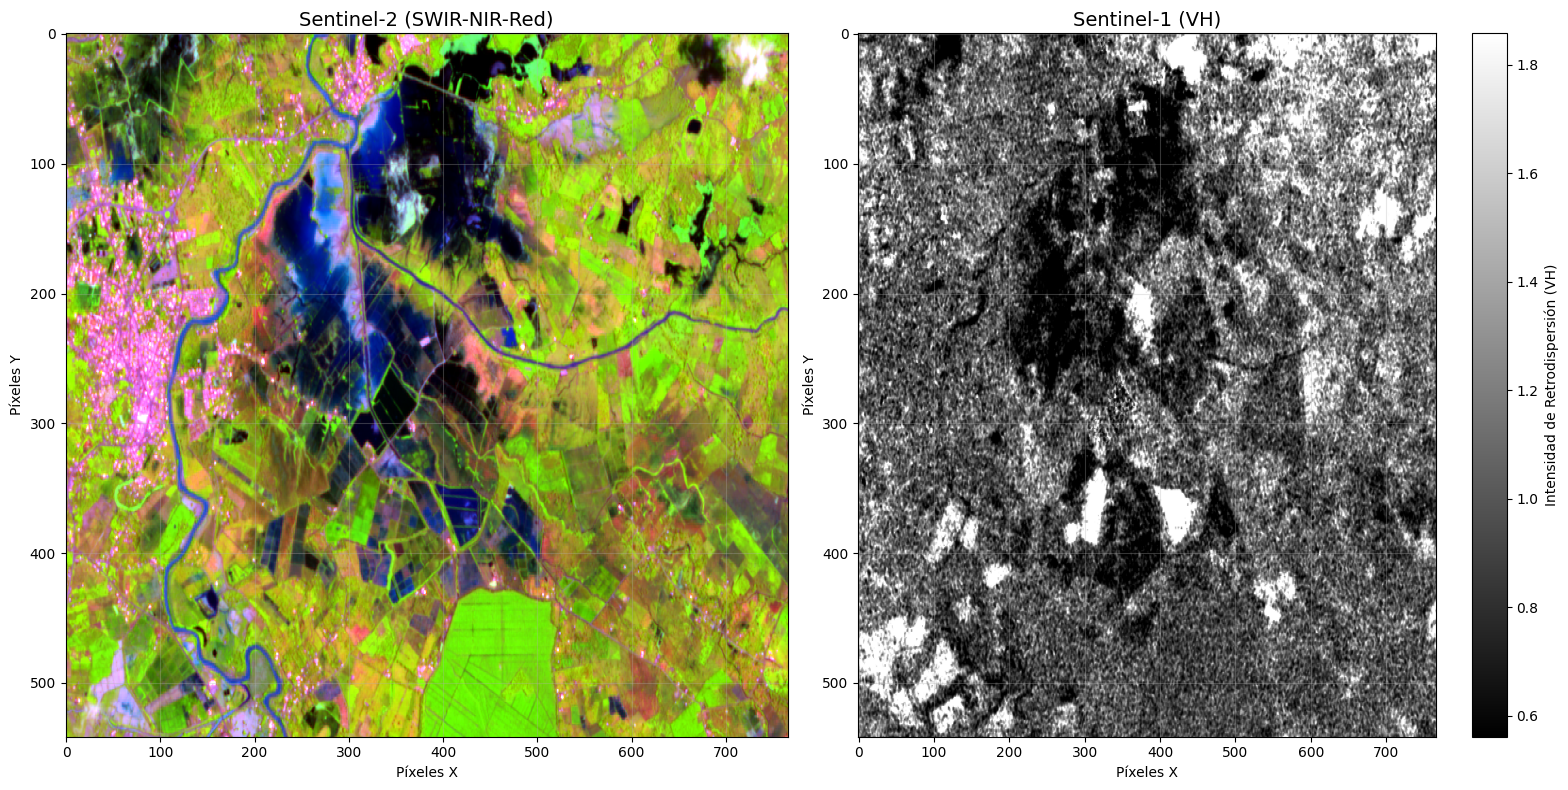


Información de las imágenes:
Sentinel-2 - Forma: (542, 766, 3)
Sentinel-1 - Forma: (542, 766)
Rango de valores S1-VH: 0.07 a 25.81


In [16]:
# Función para normalizar los datos de imagen
def normalize_image(data, percentile_range=(2, 98)):
    """Normalizar datos de imagen usando percentiles para mejor visualización"""
    if data.ndim > 2:
        # Para datos multibanda, normalizar cada banda por separado
        normalized = np.zeros_like(data, dtype=np.float32)
        for i in range(data.shape[0]):
            band_data = data[i]
            valid_data = band_data[np.isfinite(band_data)]
            if len(valid_data) > 0:
                p_low, p_high = np.percentile(valid_data, percentile_range)
                normalized[i] = np.clip((band_data - p_low) / (p_high - p_low), 0, 1)
        return normalized
    else:
        # Para datos de una sola banda
        valid_data = data[np.isfinite(data)]
        if len(valid_data) > 0:
            p_low, p_high = np.percentile(valid_data, percentile_range)
            return np.clip((data - p_low) / (p_high - p_low), 0, 1)
        return data

try:
    # Cargar imagen Sentinel-2
    with rasterio.open(s2_output_nubes30) as s2_img:
        # Obtener información sobre las bandas
        print(f"Sentinel-2: {s2_img.count} bandas, resolución: {s2_img.res}")

        # Orden de bandas según tu configuración OpenEO
        band_names = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']

        # Encontrar índices para las bandas de interés (B11=SWIR, B08=NIR, B04=Red)
        try:
            b11_idx = band_names.index('B11') + 1  # +1 para índice de rasterio
            b8_idx = band_names.index('B08') + 1
            b4_idx = band_names.index('B04') + 1

            # Leer las bandas individuales
            b11 = s2_img.read(b11_idx).astype(np.float32)
            b8 = s2_img.read(b8_idx).astype(np.float32)
            b4 = s2_img.read(b4_idx).astype(np.float32)

            # Crear composición RGB (SWIR-NIR-Red)
            s2_rgb = np.stack([b11, b8, b4], axis=0)

            # Normalizar para visualización
            s2_normalized = normalize_image(s2_rgb)

            # Transponer para matplotlib (height, width, channels)
            s2_display = np.transpose(s2_normalized, (1, 2, 0))

        except (ValueError, rasterio.errors.RasterioIOError) as e:
            print(f"Error procesando bandas S2: {e}")
            # Fallback: usar las primeras 3 bandas disponibles
            s2_rgb = s2_img.read([1, 2, 3]).astype(np.float32)
            s2_normalized = normalize_image(s2_rgb)
            s2_display = np.transpose(s2_normalized, (1, 2, 0))

    # Cargar imagen Sentinel-1
    with rasterio.open(s1_output_cambio_radar) as s1_img:
        print(f"Sentinel-1: {s1_img.count} bandas, resolución: {s1_img.res}")

        # Leer banda VH (segunda banda si está disponible)
        if s1_img.count >= 2:
            s1_vh = s1_img.read(2).astype(np.float32)  # VH
        else:
            s1_vh = s1_img.read(1).astype(np.float32)  # VV como fallback

        # Manejar valores no finitos
        s1_vh = np.where(np.isfinite(s1_vh), s1_vh, np.nan)

    # Crear visualización
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Mostrar Sentinel-2 (composición RGB)
    axes[0].imshow(s2_display, aspect='auto')
    axes[0].set_title("Sentinel-2 (SWIR-NIR-Red)", fontsize=14)
    axes[0].set_xlabel("Píxeles X")
    axes[0].set_ylabel("Píxeles Y")
    axes[0].grid(True, alpha=0.3)

    # Mostrar Sentinel-1 (VH en escala de grises)
    im1 = axes[1].imshow(s1_vh, cmap='gray', vmin=np.nanpercentile(s1_vh, 5),
                         vmax=np.nanpercentile(s1_vh, 95), aspect='auto')
    axes[1].set_title("Sentinel-1 (VH)", fontsize=14)
    axes[1].set_xlabel("Píxeles X")
    axes[1].set_ylabel("Píxeles Y")
    axes[1].grid(True, alpha=0.3)

    # Agregar barra de color para Sentinel-1
    plt.colorbar(im1, ax=axes[1], label="Intensidad de Retrodispersión (VH)")

    plt.tight_layout()
    plt.show()

    # Mostrar información adicional
    print(f"\nInformación de las imágenes:")
    print(f"Sentinel-2 - Forma: {s2_display.shape}")
    print(f"Sentinel-1 - Forma: {s1_vh.shape}")
    print(f"Rango de valores S1-VH: {np.nanmin(s1_vh):.2f} a {np.nanmax(s1_vh):.2f}")

except Exception as e:
    print(f"Error durante la visualización: {e}")
    print(f"Tipo de error: {type(e).__name__}")

    # Visualización de fallback básica
    try:
        print("\nIntentando visualización básica...")

        with rasterio.open(s2_output_nubes30) as s2_img:
            s2_basic = s2_img.read(1)

        with rasterio.open(s1_output_cambio_radar) as s1_img:
            s1_basic = s1_img.read(1)

        fig, axes = plt.subplots(1, 2, figsize=(12, 12))

        axes[0].imshow(s2_basic, cmap='viridis')
        axes[0].set_title("Sentinel-2 (Primera banda)")

        axes[1].imshow(s1_basic, cmap='gray')
        axes[1].set_title("Sentinel-1 (Primera banda)")

        plt.tight_layout()
        plt.show()

    except Exception as fallback_error:
        print(f"Error en visualización de fallback: {fallback_error}")

Sentinel-1 Pre-evento: 2 bandas, resolución: (10.0, 10.0)
Sentinel-1 Post-evento: 2 bandas, resolución: (10.0, 10.0)


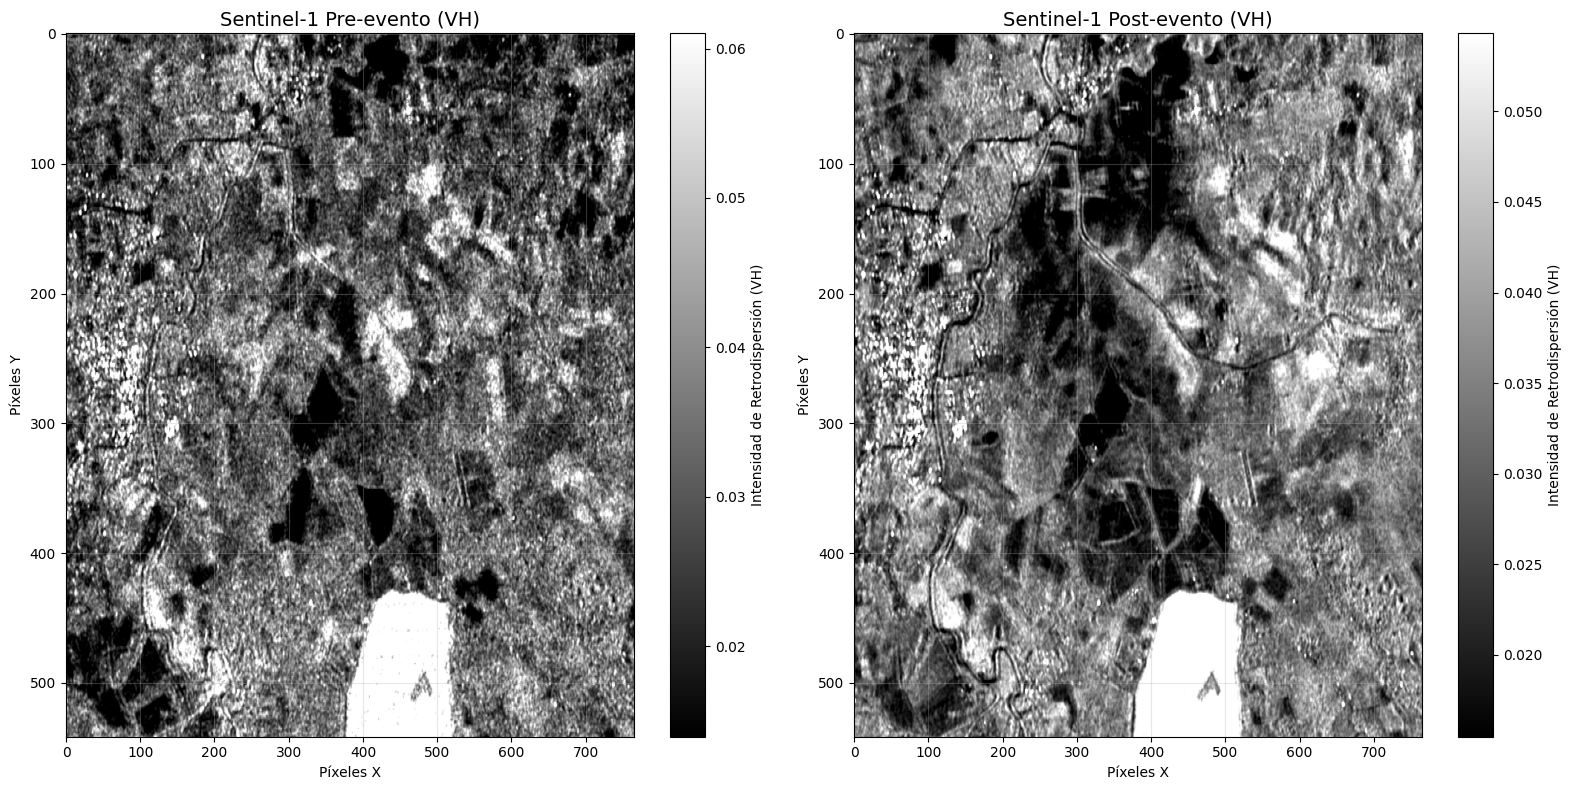

In [22]:
# Cargar imagen Sentinel-1 pre-evento
try:
    with rasterio.open(s1_output_pre_mean) as s1_pre_img:
        print(f"Sentinel-1 Pre-evento: {s1_pre_img.count} bandas, resolución: {s1_pre_img.res}")

        # Leer banda VH (segunda banda si está disponible) o VV (primera banda)
        if s1_pre_img.count >= 2:
            s1_pre_vh = s1_pre_img.read(2).astype(np.float32)  # VH
        else:
            s1_pre_vh = s1_pre_img.read(1).astype(np.float32)  # VV como fallback

        # Manejar valores no finitos
        s1_pre_vh = np.where(np.isfinite(s1_pre_vh), s1_pre_vh, np.nan)

except rasterio.errors.RasterioIOError as e:
    print(f"Error al cargar el archivo TIFF '{s1_output_pre_mean}': {e}")
    s1_pre_vh = None # Set to None to indicate loading failed

# Cargar imagen Sentinel-1 post-evento
try:
    with rasterio.open(s1_output_post_mean) as s1_post_img:
        print(f"Sentinel-1 Post-evento: {s1_post_img.count} bandas, resolución: {s1_post_img.res}")

        # Leer banda VH (segunda banda si está disponible) o VV (primera banda)
        if s1_post_img.count >= 2:
            s1_post_vh = s1_post_img.read(2).astype(np.float32)  # VH
        else:
            s1_post_vh = s1_post_img.read(1).astype(np.float32)  # VV como fallback

        # Manejar valores no finitos
        s1_post_vh = np.where(np.isfinite(s1_post_vh), s1_post_vh, np.nan)

except rasterio.errors.RasterioIOError as e:
    print(f"Error al cargar el archivo TIFF '{s1_output_post_mean}': {e}")
    s1_post_vh = None # Set to None to indicate loading failed


# Crear visualización solo si ambas imágenes se cargaron correctamente
if s1_pre_vh is not None and s1_post_vh is not None:
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Mostrar Sentinel-1 Pre-evento (VH en escala de grises)
    im_pre = axes[0].imshow(s1_pre_vh, cmap='gray', vmin=np.nanpercentile(s1_pre_vh, 5),
                           vmax=np.nanpercentile(s1_pre_vh, 95), aspect='auto')
    axes[0].set_title("Sentinel-1 Pre-evento (VH)", fontsize=14)
    axes[0].set_xlabel("Píxeles X")
    axes[0].set_ylabel("Píxeles Y")
    axes[0].grid(True, alpha=0.3)
    plt.colorbar(im_pre, ax=axes[0], label="Intensidad de Retrodispersión (VH)")


    # Mostrar Sentinel-1 Post-evento (VH en escala de grises)
    im_post = axes[1].imshow(s1_post_vh, cmap='gray', vmin=np.nanpercentile(s1_post_vh, 5),
                            vmax=np.nanpercentile(s1_post_vh, 95), aspect='auto')
    axes[1].set_title("Sentinel-1 Post-evento (VH)", fontsize=14)
    axes[1].set_xlabel("Píxeles X")
    axes[1].set_ylabel("Píxeles Y")
    axes[1].grid(True, alpha=0.3)
    plt.colorbar(im_post, ax=axes[1], label="Intensidad de Retrodispersión (VH)")

    plt.tight_layout()
    plt.show()
else:
    print("No se pudieron cargar ambas imágenes Sentinel-1.")

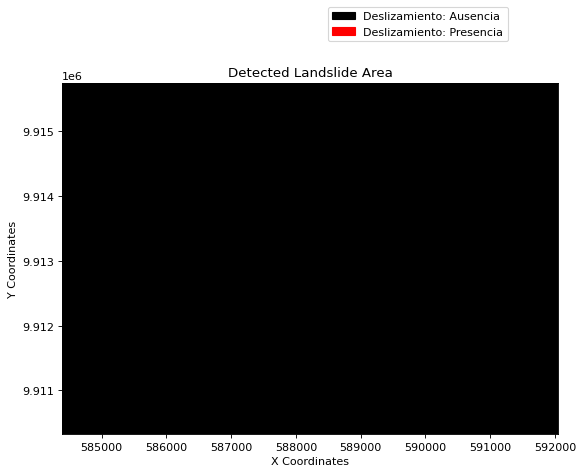

In [18]:
# Graficar el resultado
# Cargar la imagen resultante
img = rasterio.open(s1_output_cambio_radar)

# Se aplica un umbral para resaltar las áreas de deslizamiento
value = img.read(1)
cmap = matplotlib.colors.ListedColormap(["black", "red"])
fig, ax = plt.subplots(figsize=(8, 6), dpi=80)
im = show(
    ((value < -0.48) & (value > -1)),
    vmin=0,
    vmax=1,
    cmap=cmap,
    transform=img.transform,
    ax=ax,
)
values = ["Ausencia", "Presencia"]
colors = ["black", "red"]
ax.set_title("Detected Landslide Area")
ax.set_xlabel("X Coordinates")
ax.set_ylabel("Y Coordinates")
patches = [
    mpatches.Patch(color=colors[i], label="Deslizamiento: {l}".format(l=values[i]))
    for i in range(len(values))
]
fig.legend(handles=patches, bbox_to_anchor=(0.83, 1.03), loc=1)


--- Visualizando Resultados de Sentinel-1 ---


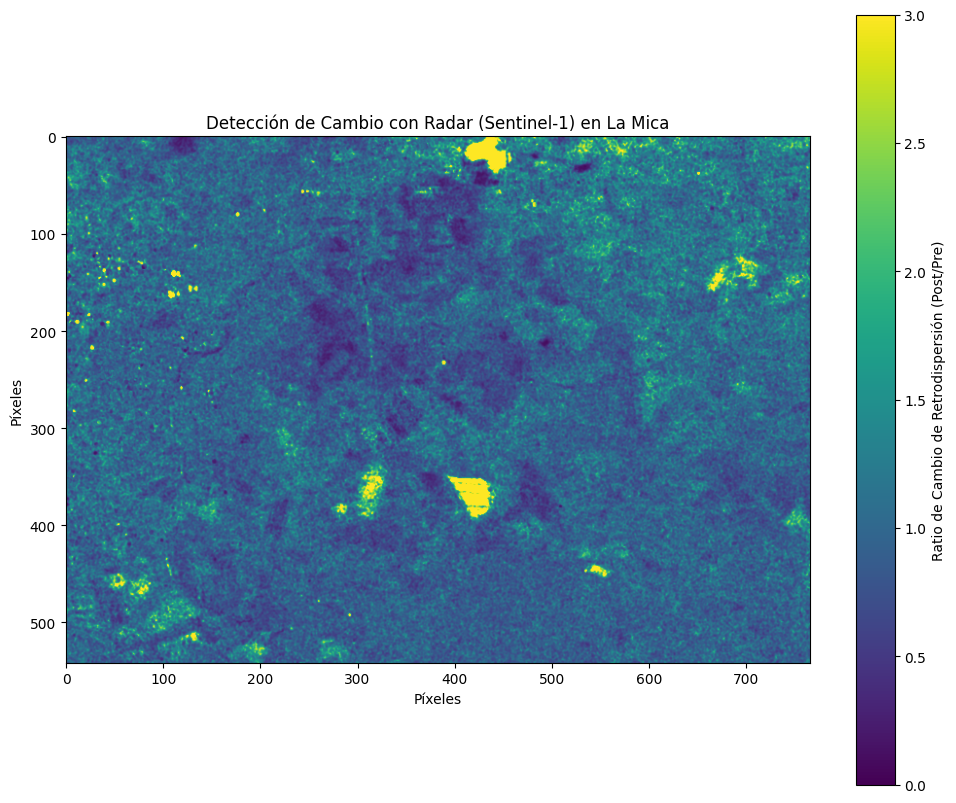

In [ ]:
# Paso 7: Visualizar el resultado de Sentinel-1 (Cambio de Radar)
import numpy as np
print("\n--- Visualizando Resultados de Sentinel-1 ---")
print(f"Mostrando '{output_file_s1}'")
try:
    with rasterio.open(output_file_s1) as img:
        value_ratio = img.read(1)

        # Eliminar valores infinitos o no válidos que puedan resultar de la división
        value_ratio[~np.isfinite(value_ratio)] = 1.0

        # --- Graficar el ratio de cambio ---
        fig, ax = plt.subplots(figsize=(12, 10), dpi=100)

        # Usamos un mapa de color que muestre bien las variaciones.
        # vmax=3 significa que estamos interesados en áreas donde la señal de radar se triplicó o más.
        im = ax.imshow(value_ratio, cmap='viridis', vmin=0, vmax=3)

        fig.colorbar(im, ax=ax, label="Ratio de Cambio de Retrodispersión (Post/Pre)")
        ax.set_title("Detección de Cambio con Radar (Sentinel-1) en La Mica")
        ax.set_xlabel("Píxeles")
        ax.set_ylabel("Píxeles")
        plt.show()
except Exception as e:
    print(f"No se pudo procesar el archivo de Sentinel-1: {e}")

# Zona Experimental

In [ ]:
## Ejemplos
from georeader.read import read_reproject_like
## DOWNLOAD S2 IMAGE
collection_name = "COPERNICUS/S2_HARMONIZED"
tile = "S2A_MSIL1C_20180519T101031_N0206_R022_T34WFU_20180519T120709"
img_col = ee.ImageCollection(collection_name)
image = img_col.filter(ee.Filter.eq("PRODUCT_ID", tile)).first()
info_img = image.getInfo()
bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12']
crs = info_img["bands"][1]["crs"]
transform = info_img["bands"][1]["crs_transform"]
projgee = {"crs": crs, "transform": transform}
img_local_s2 = ee_image.export_image_getpixels(asset_id=info_img['id'],
                                            proj=projgee,
                                            bands_gee=bands,
                                            geometry=aoi)


## DOWNLOAD S1 IMAGE
collection_name = "COPERNICUS/S1_GRD"
tile = "S1A_IW_GRDH_1SDV_20180519T050449_20180519T050514_021969_025F61_90E6"
img_col = ee.ImageCollection(collection_name)
image = img_col.filter(ee.Filter.eq("system:index", tile)).first()
info_img = image.getInfo()
crs = info_img["bands"][1]["crs"]
transform = info_img["bands"][1]["crs_transform"]
projgee = {"crs": crs, "transform": transform}
img_local_s1 = ee_image.export_image_getpixels(asset_id=info_img['id'],
                                            proj=projgee,
                                            bands_gee=['VV', 'VH'],
                                            geometry=aoi)

img_local_s1 = read_reproject_like(img_local_s1, img_local_s2)
## Mostrar imágenes
from georeader.plot import show
swirnirred = (img_local_s2.isel({"band": [bands.index(b) for b in ["B11","B8","B4"]]}) / 4_500.).clip(0,1)

fig, ax = plt.subplots(1,2,figsize=(10, 10))
show(swirnirred, ax = ax[0])

show(img_local_s1.isel({"band": [1]}), cmap="gray", vmin=-25, vmax=-5, ax=ax[1])

plt.show()